## Dataset Preparation

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("/kaggle/input/dataset2/merged_df_under.csv")  # Replace with your actual filename
df.head()

,url,type,domain,path,subdomains,url_length,count_.,count_/,count_-,count__,count_=,count_?,count_&,preprocessed,embedding
0,www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...,benign,NaN,www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...,0,52,3,4,0,0,0,0,0,tsxzsp cn tsspee oa leftpic recadastramento html,[-8.74196738e-02 6.25156537e-02 -2.64973147e-...
1,ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...,benign,NaN,ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...,0,64,2,3,5,0,0,0,0,ratemds com doctor ratings 3341912 dr serge sa...,[-1.13549024e-01 -3.49324010e-03 -5.44376113e-...
2,brainwashed.com/common/htdocs/discog/krank161....,benign,NaN,brainwashed.com/common/htdocs/discog/krank161....,0,50,2,4,0,0,0,0,0,brainwashed com common htdocs discog krank161 ...,[-5.82039244e-02 4.37722281e-02 1.08012147e-...
3,worldhockeyjerseys.com/index.html,benign,NaN,worldhockeyjerseys.com/index.html,0,33,2,1,0,0,0,0,0,worldhockeyjerseys com index html,[-3.12671848e-02 7.01173022e-02 -5.60255349e-...
4,bluemarblegameco.com/,benign,NaN,bluemarblegameco.com/,0,21,1,1,0,0,0,0,0,bluemarblegameco com,[-7.59254023e-02 -3.56400684e-02 -4.72099669e-...


In [30]:
df.columns

Index(['url', 'type', 'domain', 'path', 'subdomains', 'url_length', 'count_.',
       'count_/', 'count_-', 'count__', 'count_=', 'count_?', 'count_&',
       'preprocessed', 'embedding'],
      dtype='object')

In [31]:
df.shape

(32845, 15)

In [32]:
# Extract features and labels
X = np.array(df['embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' ')).tolist())  # Convert string embeddings to numpy array

# Initialize label encoder
label_encoder = LabelEncoder()

# Convert string labels to numerical values
y = label_encoder.fit_transform(df['type'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print class mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:", class_mapping)


Class Mapping: {'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3, 'spam': 4}


In [34]:
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)


X_train:  (26276, 384)
y_train:  (26276,)
X_test:  (6569, 384)
y_test:  (6569,)


In [35]:
# Standardize data (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

## Traditional ML Models

In [ ]:
from tqdm import tqdm

# Train and evaluate models with a progress bar
results = {}
plt.figure(figsize=(10, 5))

for i, (name, model) in enumerate(tqdm(models.items(), desc="Training Models")):
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Make predictions
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  # Probabilities (if supported)
    
    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-score": f1}
    
    # Plot confusion matrix
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


Training Models:  33%|███▎      | 1/3 [01:08<02:17, 68.82s/it]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, 
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import label_binarize

# ======================= 1️⃣ Confusion Matrix for Each Model =======================
plt.figure(figsize=(12, 4))
for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(1, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# ======================= 2️⃣ ROC Curve for Each Model =======================
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 5))

for i, (name, model) in enumerate(models.items()):
    if hasattr(model, "predict_proba"):  # Ensure model supports probability prediction
        y_proba = model.predict_proba(X_test)

        plt.subplot(1, 3, i + 1)
        for j in range(n_classes):  # Compute ROC for each class
            fpr, tpr, _ = roc_curve(y_test_bin[:, j], y_proba[:, j])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {j} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], "k--")  # Diagonal reference line
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} - ROC Curve")
        plt.legend()

plt.tight_layout()
plt.show()

# ======================= 3️⃣ Bar Chart of Performance Metrics =======================
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind="bar", figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


## Deep Learning Model (LSTM)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 920ms/step - accuracy: 0.1977 - loss: 1.8110 - val_accuracy: 0.2500 - val_loss: 1.6086
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 642ms/step - accuracy: 0.3305 - loss: 1.5897 - val_accuracy: 0.2500 - val_loss: 1.6082
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 640ms/step - accuracy: 0.2219 - loss: 1.5511 - val_accuracy: 0.2500 - val_loss: 1.6078
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 632ms/step - accuracy: 0.2937 - loss: 1.5090 - val_accuracy: 0.2500 - val_loss: 1.6075
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step - accuracy: 0.2523 - loss: 1.5507 - val_accuracy: 0.2500 - val_loss: 1.6071
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step - accuracy: 0.3297 - loss: 1.4829 - val_accuracy: 0.2500 - val_loss: 1.6067
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.2180 - loss: 1.5553 - val_accuracy: 0.2500 - val_loss: 1.6064
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - accuracy: 0.3203 - loss: 1.4732 - val_accuracy: 0.2500 - val_loss:

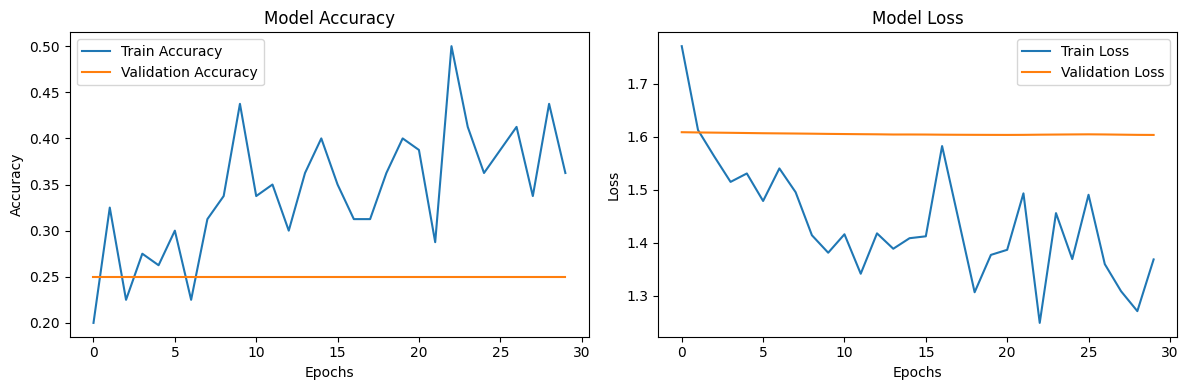

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# ===================== 1️⃣ Read Data =====================
X = df['preprocessed'].values
y = df['type']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # Convert to one-hot encoding

# ===================== 2️⃣ Reshape X for LSTM =====================
X = np.array([np.array(embedding) for embedding in X])  # Ensure it's a numpy array
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape to (samples, timesteps, features)

# ===================== 3️⃣ Train-Test Split =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# ===================== 4️⃣ Define LSTM Model =====================
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    Dropout(0.3),
    
    Dense(y_categorical.shape[1], activation="softmax")  # Multi-class classification
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ===================== 5️⃣ Train Model =====================
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# ===================== 6️⃣ Plot Training History =====================
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.tight_layout()
plt.show()

# ===================== 7️⃣ Evaluate Model =====================
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")



## Finetuning BERT

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it, accuracy=0.25, loss=1.65] 


Epoch 1: Train Acc: 0.2500, Val Acc: 0.2000


Epoch 2: 100%|██████████| 5/5 [00:20<00:00,  4.15s/it, accuracy=0.438, loss=1.43]


Epoch 2: Train Acc: 0.4375, Val Acc: 0.4000


Epoch 3: 100%|██████████| 5/5 [00:19<00:00,  4.00s/it, accuracy=0.487, loss=1.32]


Epoch 3: Train Acc: 0.4875, Val Acc: 0.4000


Epoch 4: 100%|██████████| 5/5 [00:20<00:00,  4.11s/it, accuracy=0.625, loss=1.15]


Epoch 4: Train Acc: 0.6250, Val Acc: 0.5000


Epoch 5: 100%|██████████| 5/5 [00:20<00:00,  4.20s/it, accuracy=0.725, loss=1.11]


Epoch 5: Train Acc: 0.7250, Val Acc: 0.6500


Epoch 6: 100%|██████████| 5/5 [00:19<00:00,  3.94s/it, accuracy=0.762, loss=0.87]


Epoch 6: Train Acc: 0.7625, Val Acc: 0.7000


Epoch 7: 100%|██████████| 5/5 [00:20<00:00,  4.10s/it, accuracy=0.812, loss=0.859]


Epoch 7: Train Acc: 0.8125, Val Acc: 0.7000


Epoch 8: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it, accuracy=0.9, loss=0.944]  


Epoch 8: Train Acc: 0.9000, Val Acc: 0.6500


Epoch 9: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, accuracy=0.9, loss=0.683]  


Epoch 9: Train Acc: 0.9000, Val Acc: 0.6500


Epoch 10: 100%|██████████| 5/5 [00:20<00:00,  4.20s/it, accuracy=0.863, loss=0.559]


Epoch 10: Train Acc: 0.8625, Val Acc: 0.6000


Epoch 11: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it, accuracy=0.912, loss=0.576]


Epoch 11: Train Acc: 0.9125, Val Acc: 0.6500


Epoch 12: 100%|██████████| 5/5 [00:19<00:00,  3.97s/it, accuracy=0.887, loss=0.581]


Epoch 12: Train Acc: 0.8875, Val Acc: 0.7000


Epoch 13: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it, accuracy=0.912, loss=0.449]


Epoch 13: Train Acc: 0.9125, Val Acc: 0.7000


Epoch 14: 100%|██████████| 5/5 [00:20<00:00,  4.09s/it, accuracy=0.988, loss=0.287]


Epoch 14: Train Acc: 0.9875, Val Acc: 0.7000


Epoch 15: 100%|██████████| 5/5 [00:19<00:00,  3.95s/it, accuracy=1, loss=0.348]


Epoch 15: Train Acc: 1.0000, Val Acc: 0.7500


Epoch 16: 100%|██████████| 5/5 [00:20<00:00,  4.10s/it, accuracy=1, loss=0.429]


Epoch 16: Train Acc: 1.0000, Val Acc: 0.7500


Epoch 17: 100%|██████████| 5/5 [00:20<00:00,  4.18s/it, accuracy=0.988, loss=0.261]


Epoch 17: Train Acc: 0.9875, Val Acc: 0.7500


Epoch 18: 100%|██████████| 5/5 [00:19<00:00,  3.99s/it, accuracy=1, loss=0.223]


Epoch 18: Train Acc: 1.0000, Val Acc: 0.7000


Epoch 19: 100%|██████████| 5/5 [00:21<00:00,  4.34s/it, accuracy=1, loss=0.168]


Epoch 19: Train Acc: 1.0000, Val Acc: 0.7000


Epoch 20: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it, accuracy=1, loss=0.155]


Epoch 20: Train Acc: 1.0000, Val Acc: 0.7500


Epoch 21: 100%|██████████| 5/5 [00:21<00:00,  4.23s/it, accuracy=1, loss=0.125]


Epoch 21: Train Acc: 1.0000, Val Acc: 0.7500


Epoch 22: 100%|██████████| 5/5 [00:20<00:00,  4.18s/it, accuracy=1, loss=0.125]


Epoch 22: Train Acc: 1.0000, Val Acc: 0.7500


Epoch 23: 100%|██████████| 5/5 [00:21<00:00,  4.37s/it, accuracy=1, loss=0.111] 


Epoch 23: Train Acc: 1.0000, Val Acc: 0.7500


Epoch 24: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it, accuracy=1, loss=0.0952]


Epoch 24: Train Acc: 1.0000, Val Acc: 0.7500


Epoch 25: 100%|██████████| 5/5 [00:20<00:00,  4.07s/it, accuracy=1, loss=0.11]  


Epoch 25: Train Acc: 1.0000, Val Acc: 0.8000


Epoch 26: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it, accuracy=1, loss=0.0789]


Epoch 26: Train Acc: 1.0000, Val Acc: 0.8000


Epoch 27: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it, accuracy=1, loss=0.0635]


Epoch 27: Train Acc: 1.0000, Val Acc: 0.8000


Epoch 28: 100%|██████████| 5/5 [00:20<00:00,  4.11s/it, accuracy=1, loss=0.0518]


Epoch 28: Train Acc: 1.0000, Val Acc: 0.8000


Epoch 29: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it, accuracy=1, loss=0.0612]


Epoch 29: Train Acc: 1.0000, Val Acc: 0.8000


Epoch 30: 100%|██████████| 5/5 [00:21<00:00,  4.34s/it, accuracy=1, loss=0.055] 


Epoch 30: Train Acc: 1.0000, Val Acc: 0.8000


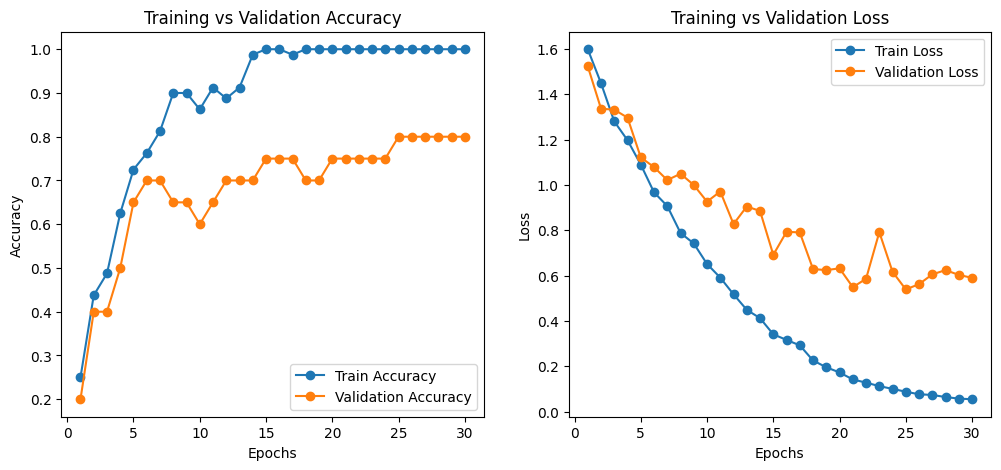

Test Accuracy: 0.8000


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# ===================== 1️⃣ Load Tokenizer =====================
MODEL_NAME = "bert-base-uncased"  
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# ===================== 2️⃣ Read Text and Encode Labels =====================
X = df['preprocessed'].values
y = df['type']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ===================== 3️⃣ Tokenize Text Data =====================
max_length = 128  

tokens = tokenizer(list(X), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
input_ids, attention_masks = tokens["input_ids"], tokens["attention_mask"]
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# ===================== 4️⃣ Train-Test Split =====================
X_train, X_test, y_train, y_test, attention_train, attention_test = train_test_split(
    input_ids, y_tensor, attention_masks, test_size=0.2, random_state=42, stratify=y_encoded
)

# ===================== 5️⃣ Create PyTorch Dataset =====================
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx]
        }

train_dataset = TextDataset(X_train, attention_train, y_train)
test_dataset = TextDataset(X_test, attention_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ===================== 6️⃣ Load Pre-trained BERT Model =====================
num_classes = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ===================== 7️⃣ Define Optimizer & Loss Function =====================
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# ===================== 8️⃣ Training Loop =====================
epochs = 30
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_loader, leave=True)
    
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item(), accuracy=correct/total)

    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)
    train_losses.append(total_loss / len(train_loader))

    # ===================== 9️⃣ Validation =====================
    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}: Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

# ===================== 🔟 Plot Training & Validation Curves =====================
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


# ===================== 9️⃣ Evaluate Model =====================
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")
